In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cg, minimize
import h5py
c = 2.99792458e8   # m/s

In [2]:
def doppler(v):
    frac = (1. - v/c) / (1. + v/c)
    return np.sqrt(frac)
        
def state(xs, xps, yps):
    # returns a, b such that ys = a * xs + b
    yps = np.concatenate((yps, [yps[-1]]), axis=0) # hack for end of grid
    xps = np.concatenate((xps, [xps[-1]+1.]), axis=0) # hack for end of grid
    mps = np.searchsorted(xps, xs, side='left')
    yps = np.concatenate(([yps[0]], yps), axis=0) # hack for end of grid
    xps = np.concatenate(([xps[0]-1.], xps), axis=0) # hack for end of grid
    ehs = (yps[mps+1] - yps[mps])/(xps[mps+1] - xps[mps])
    bes = yps[mps] - ehs * xps[mps]
    return ehs, bes
    
def P(ehs, bes, xs):
    return ehs * xs + bes
    
def dPdx(ehs):
    return ehs # lol
    
def Pdot(lnlambdas, lnlambdaps, lnfluxps, v):
    if v.ndim == 0:
        N = 1
    else:
        N = len(v)
    M = len(lnlambdas)
    lnlambdas_shifted = np.tile(lnlambdas, (N,1)) + np.tile(np.log(doppler(v)), (M,1)).T # N x M
    ehs, bes = state(lnlambdas_shifted, lnlambdaps, lnfluxps)
    return P(ehs, bes, lnlambdas_shifted) # this is lnfluxs

In [3]:
f = h5py.File('../data/hip54287.hdf5', 'r')

data = np.copy(f['data'])
data_xs = np.log(np.copy(f['xs']))
ivars = np.copy(f['ivars'])
true_rvs = np.copy(f['true_rvs'])
bervs = np.copy(f['berv']) * -1.e3
N = len(bervs)

for i in xrange(len(data)):
    data[i] /= np.median(data[i])
    
data = np.log(data)

In [4]:
def make_template(all_data, rvs, xs, dx):
    """
    `all_data`: `[N, M]` array of pixels
    `rvs`: `[N]` array of RVs
    `xs`: `[M]` array of wavelength values
    `dx`: linear spacing desired for template wavelength grid (A)
    """
    (N,M) = np.shape(all_data)
    all_xs = np.empty_like(all_data)
    for i in range(N):
        all_xs[i,:] = xs + np.log(doppler(rvs[i])) # shift to rest frame
    all_data, all_xs = np.ravel(all_data), np.ravel(all_xs)
    tiny = 10.
    template_xs = np.arange(min(all_xs)-tiny*dx, max(all_xs)+tiny*dx, dx)
    template_ys = np.nan + np.zeros_like(template_xs)
    for i,t in enumerate(template_xs):
        ind = (all_xs >= t-dx/2.) & (all_xs < t+dx/2.)
        if np.sum(ind) > 0:
            template_ys[i] = np.nanmedian(all_data[ind])
    ind_nan = np.isnan(template_ys)
    template_ys[ind_nan] = np.interp(template_xs[ind_nan], template_xs[~ind_nan], template_ys[~ind_nan])
    return template_xs, template_ys

def subtract_template(data_xs, data, model_xs_t, model_ys_t, rvs_t):
    (N,M) = np.shape(data)
    data_sub = np.copy(data)
    for n,v in enumerate(rvs_t):
        model_ys_t_shifted = Pdot(data_xs, model_xs_t, model_ys_t, v)
        data_sub[n,:] -= np.ravel(model_ys_t_shifted)
        if n == 0:
            plt.plot(data_xs, data[n,:], color='k')
            plt.plot(data_xs, data_sub[n,:], color='blue')
            plt.plot(data_xs, np.ravel(model_ys_t_shifted), color='red')
    return data_sub

In [5]:
x0_star = bervs
x0_t = np.zeros(N)
model_xs_star, model_ys_star = make_template(data, x0_star, data_xs, np.log(6000.01) - np.log(6000.))
model_xs_t, model_ys_t = make_template(data, x0_t, data_xs, np.log(6000.01) - np.log(6000.))

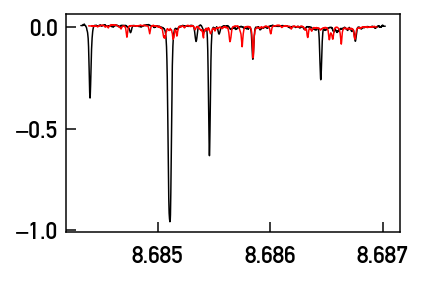

In [6]:
plt.plot(model_xs_star, model_ys_star, color='k')
plt.plot(model_xs_t, model_ys_t, color='red')

In [7]:
def chisq_star(rvs_star, rvs_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    pd_star = Pdot(data_xs, model_xs_star, model_ys_star, rvs_star)
    pd_t = Pdot(data_xs, model_xs_t, model_ys_t, rvs_t)
    pd = pd_star + pd_t
    return np.sum((data - pd)**2 * ivars)

def chisq_t(rvs_t, rvs_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    pd_star = Pdot(data_xs, model_xs_star, model_ys_star, rvs_star)
    pd_t = Pdot(data_xs, model_xs_t, model_ys_t, rvs_t)
    pd = pd_star + pd_t
    return np.sum((data - pd)**2 * ivars)


In [8]:
soln_star =  minimize(chisq_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
soln_t =  minimize(chisq_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']

x0_star = soln_star
x0_t = soln_t
print np.std(x0_star - true_rvs)
print np.std(x0_t)

         Current function value: 884383.195249
         Iterations: 112
         Function evaluations: 15263
         Gradient evaluations: 198
         Current function value: 883637.903251
         Iterations: 102
         Function evaluations: 10396
         Gradient evaluations: 135
39.3675713637
81.6691932042


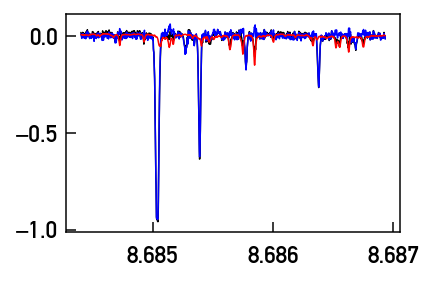

In [9]:
data_star = subtract_template(data_xs, data, model_xs_t, model_ys_t, x0_t)

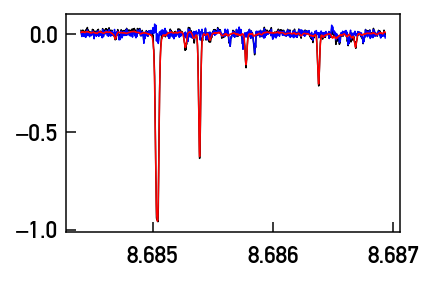

In [10]:
data_t = subtract_template(data_xs, data, model_xs_star, model_ys_star, x0_star)

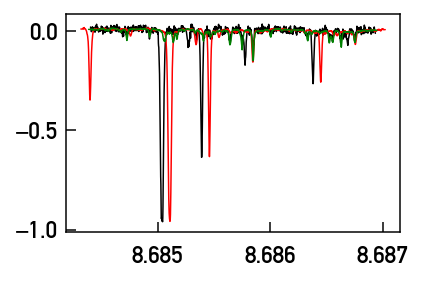

In [11]:
plt.plot(data_xs, data[0,:], color='black')
plt.plot(model_xs_star, model_ys_star, color='red')
plt.plot(model_xs_t, model_ys_t, color='green')

In [ ]:
soln_star =  minimize(chisq_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
soln_t =  minimize(chisq_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']


print np.std(soln_star - true_rvs)
print np.std(soln_t)

In [ ]:
for n in range(5):
    x0_star = soln_star
    x0_t = soln_t

    data_star = subtract_template(data_xs, data, model_xs_t, model_ys_t, x0_t)
    data_t = subtract_template(data_xs, data, model_xs_star, model_ys_star, x0_star)

    model_xs_star, model_ys_star = make_template(data_star, x0_star, data_xs, np.log(6000.01) - np.log(6000.))
    model_xs_t, model_ys_t = make_template(data_t, x0_t, data_xs, np.log(6000.01) - np.log(6000.))

    soln_star =  minimize(chisq_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
    soln_t =  minimize(chisq_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']

    print "iter {0}: star std = {1:.2f}, telluric std = {2:.2f}".format(n, np.std(soln_star - true_rvs), np.std(soln_t))

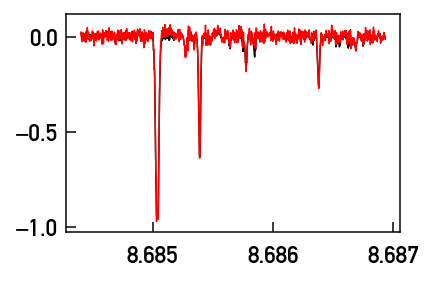

In [49]:
plt.plot(data_xs, data[0,:], color='k')
plt.plot(data_xs, data_star[0,:] + data_t[0,:], color='red')